In [1]:
#!pip install biopython
from Bio import SeqIO 
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
reads = list(SeqIO.parse('single_Pfal_dat.fq','fastq'))

In [4]:
Genome = list(SeqIO.parse('data','fasta'))

In [5]:
def complementInverse(w):
    wCI = []
    for i in range(len(w)):
        li = w[-i-1]
        if li not in "ATCG":
            raise Exception("Letter not in alphabet")
        lCI = 'A'*int(li=='T') + 'T'*int(li=='A') + 'C'*int(li=='G') + 'G'*int(li=='C')
        wCI.append(lCI)
    return ''.join(wCI)

In [6]:
def circularShift(T,k):
    if k<0:
        raise Exception("k must be positive")
    return T[k:]+T[0:k]

def BWT(S):
    if S[len(S)-1]!='$':
        S += '$'
        
    circShifts = []
    for k in range(len(S)):
        circShifts.append(circularShift(S,k))
    circShifts.sort()
    
    bwt = []
    for shift in circShifts:
        bwt.append(shift[len(S)-1])
        
    return bwt

In [7]:
def suffix_list(T): # O(n log n)
    """
    Compute the suffix list
    
    Args:
        T (str): string
    
    Return:
        list of strings: suffix list
    """
    suffix_list = [T[i:] for i in range(len(T))] # O(n)
    sorted(suffix_list,reverse=True) # O(n log n)
    return suffix_list

def suffix_table(T): # O(n log n)
    """
    Compute the suffix table
    
    Args:
        T (str): string
    
    Return:
        list of tuples (suffix,location): suffix table
    """
    suffix_list = [T[i:] for i in range(len(T))] 
    suffix_table = sorted((e,i) for i,e in enumerate(suffix_list))
    return suffix_table

def BWT_suffix_table(T,end_of_string="$"): # O(n log n)
    """
    Compute the BWT from the suffix table
    
    Args:
        T (str): string
        end_of_string (char): end of string character to append
    
    Return:
        bwt (str): BWT
    """
    if T[-1]!=end_of_string :
        T += end_of_string
    ST = suffix_table(T) # O(n log n)
    bwt = ""
    index = []
    for s,i in ST: # O(n)
        bwt += T[i-1]
        index.append(i-1)
    return bwt, index

In [8]:
from collections import Counter 

def occurrence_indexer(S):
    """
    Number of past occurrences of each char in S
    
    Args:
        S (str): string
        
    Return:
        table of int : number of past occurrences of the char
    """
    K = []
    last_index = {}
    for s in S:
        if s not in last_index: 
            last_index[s] = 0
        K.append(last_index[s])
        last_index[s] += 1
    return(K)

def last2first(counts,k,X):
    """
    k + nbr of occurrences of letters < X 
    
    Args:
        counts (Counter): nbr of each char in the text
        k : int
        X : char
        
    Return:
        int : k + nbr of occurrences of letters < X 
    """
    a = [counts[char] for char in counts if char < X]
    return k + sum(a)
    
def efficient_inverse_BWT(bwt,end_of_string="$"):
    """
    Inverse the BWT
    
    Args:
        bwt (str): bwt of a string T
        last_character (char): which is the end of string character?
    
    Return:
        T (str): BWT^{-1} of bwt
    """    
    K = occurrence_indexer(bwt)
    counts = Counter(bwt)
    X = bwt[0]
    k = K[0]
    S = end_of_string
    while X != end_of_string:
        S = X+S
        j = last2first(counts,k,X)
        X = bwt[j]
        k = K[j]
    return(S)

In [9]:
  def get_first_occurrence(L,X):
    for i,l in enumerate(L):
        if l == X:
            return(i)
        
def pattern_matching_BWT(T,pattern):
    """
    Search a patter in a String using the BWT
    
    Args:
        S (str): string
        pattern (str): pattern
    
    Return:
        bool: true if the pattern is in the string    
    """
    L,_ = BWT_suffix_table(T)
    K = occurrence_indexer(L)
    counts = Counter(L)
    e = 0
    f = len(L)
    i = len(pattern) - 1
    while e < f and i >= 0:
        X = pattern[i]
        first_occurence_in_L_ef = get_first_occurrence(L[e:f],X)
        if first_occurence_in_L_ef is None:
            return False
        else:
            r = first_occurence_in_L_ef+e
        #print(first_occurence_in_L_ef,L[e:f],r,X,L[r])
        
        last_occurence_in_L_ef = get_first_occurrence(L[e:f][::-1],X)
        if last_occurence_in_L_ef is None:
            return False
        else:
            s = f-last_occurence_in_L_ef-1
        #print(last_occurence_in_L_ef,L[e:f],s,X,L[s])
        
        e = last2first(counts,K[r],X)
        f = last2first(counts,K[s],X)+1
        i -= 1
        #print(r,s,e,f)
    return(i<0)



In [10]:
def rankBWT(bwt):
    """
    Number of past occurrences of each char in S
    
    Args:
        S (str): string
        
    Return:
        table of int : number of past occurrences of the char
    """
    K = []
    tot = {}
    for s in bwt:
        if s not in tot: 
            tot[s] = 0
        K.append(tot[s])
        tot[s] += 1
    return(K,tot)
    

In [11]:
def invBWT(bwt,A):
    A = sorted(A)
    #count = {a:0 for a in A}
    count = {}
    K = []
    for i in range(len(bwt)):
        if bwt[i] in count:
            count[bwt[i]] += 1
        else:
            count[bwt[i]] = 1
        K.append(count[bwt[i]])
    X = bwt[0]
    k = K[1]
    S = '$'
    while X != '$':
        S = X+S
        j = k
        i = 0
        while A[i] != X:
            j += count[A[i]]
            i += 1
        X = bwt[j]
        k = K[j]
    return S

In [12]:
def firstColMap(tots):
    """ Return a map from characters to the range of cells in the first
    column containing the character. 
    char : (first index, last index+1)"""
    first = {}
    totc = 0
    for c, count in sorted(tots.items()):
        first[c] = (totc, totc + count)
        totc += count
    return first

In [13]:
def searching(bwt, SAT, W):

    # Not case sensitive, make everything uppercase
    bwt = bwt.upper()
    W = W.upper()
    
    # Perdorm a BWT on text T and get the indexes corresponding to the Suffix Array of T
    #bwt, SAT = BWT_suffix_table(T)
    # LF mapping
    # F = sorted(bwt) # no need to store it
    rank, totCount = rankBWT(bwt)
    Fmap = firstColMap(totCount)
    del totCount

    
    #print('\nbwt :', sys.getsizeof(bwt),
    #'\nSAT :', sys.getsizeof(SAT),
    #'\nrank :', sys.getsizeof(rank),
    #'\nFmap :', sys.getsizeof(Fmap),)

    letter = W[-1] # last letter of the word W
    if letter not in Fmap:
        return -1, "Word not in text"
    fi, li = Fmap[letter] # find occurences of letter in F
    
    for i in range(2,len(W)+1):
        letter = W[-i] # search W by going backward through it
        if letter not in Fmap:
            return -1, "Word not in text"

        j = fi
        foundRankf = False
        while j < li:
            if bwt[j] == letter:
                if not foundRankf:
                    rankf = rank[j] # get the rank of the first occurence of letter (followed by W suffix)
                    foundRankf = True
                rankl = rank[j] # get the rank of the last occurence of letter (followed by W suffix)
            j += 1
        
        if not foundRankf:
            return -1, "Word not in text"
        
        fi, li = Fmap[letter] # find occurences of letter in F
        fi += rankf # find first occurence of letter in F (followed by W suffix)
        li = fi + rankl-rankf +1 # find last occurence of letter in F (followed by W suffix)

    return [x+1 for x in SAT[fi:li]]
    

In [14]:
def searchWord(cutSeq, n, k, words):

    bwtSeq = []
    satSeq = []
    for s in cutSeq:
        bwt, sat = BWT_suffix_table(s)
        bwtSeq.append(bwt)
        satSeq.append(sat)

    foundRead = []
    for i in range(len(cutSeq)):
        res = searching(bwtSeq[i], satSeq[i], words)
        if res[0] != -1 :
            resi = [x+i*(n-k) for x in res]
            foundRead += resi

    return np.unique(foundRead)

In [15]:
def GenomeBWT(genome):
    bwtGen = []
    satGen = []
    
    wholeGenomeCutted = []
    n = int(1e4)
    overlap = 100
    for i in range(len(Genome)):
        chromosome = Genome[i].seq.upper()
        cutChr = cutSequence(chromosome, n, overlap)
        wholeGenomeCutted.append(cutChr)
        
    for c in range(len(genome)):
        print('chr',c)
        chromosome = wholeGenomeCutted[c]
        bwtChr = []
        satChr = []
        for seq in chromosome:
            bwt, sat = BWT_suffix_table(seq)
            bwtChr.append(bwt)
            satChr.append(sat)
        bwtGen.append(bwtChr)
        satGen.append(satChr)
    return (bwtGen,satGen)

In [16]:
def searchChr(bwtChr,satChr, word):
    n = int(1e4)
    overlap = 100

    foundRead = []
    for i in range(len(bwtChr)):
        res = searching(bwtChr[i], satChr[i], word)
        if res[0] != -1 :
            resi = [x+i*(n-overlap) for x in res]
            foundRead += resi

    return np.unique(foundRead)

In [17]:
def searchGen(bwtGen,satGen, word):
   
    foundGen = {}
    for i in range(len(bwtGen)):
        foundChr = searchChr(bwtGen[i],satGen[i], word)
        foundGen[i] = foundChr
        
    return foundGen

In [18]:
def getKmers(read, k):
    read = str(read)
    kmers = []
    iF = 0
    iL = iF + k

    Continuer = True

    while Continuer:
        if iL >= len(read):
            Continuer = False
            iL = len(read)
        kmers.append(read[iF:iL])
        iF +=1
        iL = iF + k
        if Continuer and iF >= len(read):
            Continuer = False
            
    return kmers

In [19]:
def SWmatrix2strings(S,T,D,F):
    """
    Smith-Waterman matrix to aligned strings

    Args:
        S (str): first string
        T (str): second string
        D (np.array or list of lists): Decision matrix

    Returns:
        S_aligned (str): first string aligned
        T_aligned (str): second string aligned
        
    """    
    S_WITH_GAP = -1
    T_WITH_GAP = 1
    S_T_ALIGN = 0
    i,j = np.unravel_index(F.argmax(),F.shape)
    end = (i,j)
    S_aligned = ""
    T_aligned = ""
    while i > 0 and j > 0:
        #print(i,j,T[j-1],S[i-1],D[i,j])
        #print(S_aligned,T_aligned)
        #print(S[i-1], S_aligned)
        if D[i,j] == S_WITH_GAP:
            S_aligned = S[i-1]+S_aligned
            T_aligned = "_"+T_aligned
            #print(S_aligned,T_aligned)
            i -= 1
        elif D[i,j] == T_WITH_GAP:
            T_aligned = T[j-1]+ T_aligned
            S_aligned = "_"+S_aligned
            #print(S_aligned,T_aligned)
            j -= 1
        elif D[i,j] == S_T_ALIGN:
            S_aligned = S[i-1] + S_aligned
            T_aligned = T[j-1] + T_aligned
            #print(S_aligned,T_aligned)
            j -= 1
            i -= 1
        #elif D[i,j] == NO_ALIGN:
        else:
            break
    start = (i,j)
    return(S_aligned,T_aligned,start,end)

def Smith_Waterman(S,T,return_matrix=False):
    """
    Needleman-Wunch 

    Args:
        S (str): first string
        T (str): second string
        return_matrix (bool): If true return matrix, else return the aligned strings

    Returns:
        F,D (np.array, np.array): If return_matrix is true F is the score matrix and D the decision matrix
        S_aligned, T_aligned (str,str): If return_matrix is false first and second strings aligned
        
    """
    T_WITH_GAP = 1
    S_WITH_GAP = -1
    S_T_ALIGN = 0
    NO_ALIGN = 2
    decision = [T_WITH_GAP,S_WITH_GAP,S_T_ALIGN,NO_ALIGN]
    F = np.zeros((len(S)+1,len(T)+1))
    D = np.zeros((len(S)+1,len(T)+1))
    D[0,1:] = T_WITH_GAP 
    D[1:,0] = S_WITH_GAP 
    for i in range(1,len(S)+1):
        for j in range(1,len(T)+1):
            comparison = int(S[i-1]==T[j-1])*2-1
            options = [F[i,j-1] - 1, F[i-1,j] - 1, F[i-1,j-1] + comparison, 0]
            F[i,j] = options[0]
            D[i,j] = T_WITH_GAP
            for o,val in enumerate(options):
                if val > F[i,j]:
                    F[i,j] = val
                    D[i,j] = decision[o]
    if return_matrix:
        return F,D
    else:
        return SWmatrix2strings(S,T,D,F)

In [20]:
def cutSequence(seqToCut, n, k):
    cutSeq = []
    iF = 0
    iL = iF + n

    Continuer = True

    while Continuer:
        if iL >= len(seqToCut):
            Continuer = False
            iL = len(seqToCut)
        cutSeq.append(seqToCut[iF:iL])
        iF += n - k
        iL = iF + n -1
        if Continuer and len(seqToCut) - iF <= k :
            Continuer = False
            
    return cutSeq

In [117]:
def MappingKmers(Read,bwtGen,satGen, iCh,k):
   
    ReadSeq = str(Read.seq).upper()
    
    KmersRead = getKmers(ReadSeq, k)
    uniqueKmers = np.unique(KmersRead)
    kmerDict = {k : [] for k in uniqueKmers}
    for i in range(len(KmersRead)):
        kmerDict[KmersRead[i]].append(i)
    
    ChrKmersPos = []
    #ChrKmersFound = {}
    ChrKmersFreq = {}
    for w in uniqueKmers:
        foundChr = searchChr(bwtGen[iCh],satGen[iCh], w)
        #ChrKmersFound[w] = foundChr
        ChrKmersFreq[w] = len(foundChr)
        for i in foundChr:
            ChrKmersPos.append((w,i))
            
            
    # Filter out very frequent k-mers
    ChrKmersPosFilt = []
    threshold = np.percentile(list(ChrKmersFreq.values()),75)
    for t in ChrKmersPos:
        if ChrKmersFreq[t[0]] < threshold:
            ChrKmersPosFilt.append(t)

    # Sort k-mers along chromosome
    ChrKmersPosFiltdf = pd.DataFrame(ChrKmersPosFilt, columns=['K-mer','i']).sort_values('i')
    SortedKmers = list(ChrKmersPosFiltdf.loc[:,'K-mer'])

    # Chromosom-read k-mers correspondance  
    corrRead = [] # indices des k-mers de la lecture mis en correspondance avec les k-mers du génome
    i = -1
    for k in SortedKmers: # Pour chaque k-mer dans le génome
        i += 1
        listI = kmerDict[k] # liste des positions possibles dans la lecture
        # Si qu'une position ou que début de la mise en correspondance 
        # ou qu'on a déjà une fin de lecture mis en correspondance juste avant
        if len(listI) == 1 or len(corrRead) == 0 or listI[-1]-corrRead[-1]<=0:
            corrRead.append(listI[0]) # on met en correspondance k du génome avec la première occurence de k dans le read
        else:
            # différence entre les posible occurences de k dans read 
            # avec l'index de la dernière correspondance faite
            dist = np.array(listI)-corrRead[-1]
            j = 0
            # on cherche l'occurence pouvant étant après l'index de la dernière correspondance faite
            # et la plus proche de celle-ci
            while dist[j]<=0:
                j+=1

            corrRead.append(listI[j])    
    
    x = corrRead
    y = list(ChrKmersPosFiltdf.loc[:,'i'])
    
    return (x,y)

In [136]:
def findRead(x,y,Read,Genome,iCh):
    ReadSeq = str(Read.seq).upper()
    
    yRange = (min(y),max(y))
    ySpan = yRange[1]-yRange[0]
    epsilon = len(ReadSeq)*2

    mi = yRange[0]
    ma = mi+epsilon
    i = 0
    yMov = [0]*ySpan
    for j in range(len(y)):
        if y[j] < ma:
            yMov[i] += 1
        else:
            lastyMov = yMov[i]
            while y[j] >= ma:
                i += 1
                mi += 1
                ma += 1
                yMov[i] = yMov[i-1]
                jMi = j-yMov[i-1]
                while y[jMi] < mi:
                    yMov[i] -= 1 
                    jMi += 1
            yMov[i] += 1
     
    # Supposons que la lecture ne peux pas être présente plus d'une fois dans un chromosome.
    iStart = yMov.index(max(yMov))+yRange[0]
    iEnd = iStart + epsilon
    iStart -= int(len(ReadSeq)/2)
    iEnd += int(len(ReadSeq)/2)
    #print(iStart)
    #print(iEnd)
    
    S = str(Genome[iCh].seq)[iStart:iEnd].upper()
    T = ReadSeq
    F,D = Smith_Waterman(S,T,True)
    seqChr,seqRead,istart,iend = SWmatrix2strings(S,T,D,F)
    
    mappedTo = (istart[0]+iStart,iend[0]+iStart)
    Fscore = np.amax(F)
    #print(Fscore)
    
    this = np.reshape([iCh,mappedTo[0],mappedTo[1],Fscore],(1, 4))
    thisMapping = pd.DataFrame(this,index = [Read.id],columns=['chr', 'iStart', 'iEnd', 'Fscore'])
    
    return thisMapping

# Création de la variable de stockage

In [21]:
storeMapping = pd.DataFrame(columns=['chr', 'iStart', 'iEnd', 'Fscore'])

# Préprocessing du génome

On applique

In [22]:
bwtGen, satGen = GenomeBWT(Genome)

chr 0
chr 1
chr 2
chr 3
chr 4
chr 5
chr 6
chr 7
chr 8
chr 9
chr 10
chr 11
chr 12
chr 13
chr 14


# Cutting read into k-mers

# Find lecture in genome

Mapping = pd.DataFrame(columns=['chr', 'iStart', 'iEnd', 'Fscore'])

S = str(Genome[iCh].seq)[iStart:iEnd].upper()
T = ReadSeq
F,D = Smith_Waterman(S,T,True)
seqChr,seqRead,istart,iend = SWmatrix2strings(S,T,D,F)

mappedTo = (istart[0]+iStart,iend[0]+iStart)
Fscore = np.amax(F)

this = np.reshape([iCh,mappedTo[0],mappedTo[1],Fscore],(1, 4))
thisMapping = pd.DataFrame(this,index = [Read.id],columns=['chr', 'iStart', 'iEnd', 'Fscore'])
Mapping = Mapping.append(thisMapping)

#return Mapping

In [138]:
A = findRead(x,y,reads[iRead],Genome,iCh)

In [139]:
A

,chr,iStart,iEnd,Fscore
NC_004325.2-99998,0.0,471737.0,471837.0,100.0


In [141]:
iRead = 2
k = 10
Read = reads[iRead]
ReadSeq = str(Read.seq).upper()

In [142]:
KmersRead = getKmers(ReadSeq, k)
uniqueKmers = np.unique(KmersRead)
kmerDict = {k : [] for k in uniqueKmers}
for i in range(len(KmersRead)):
    kmerDict[KmersRead[i]].append(i)

                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  0.0  471737.0  471837.0   100.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  1.0  253568.0  253668.0    56.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  2.0  609541.0  609646.0    38.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  3.0  228669.0  228761.0    40.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  4.0  671927.0  672019.0    43.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  5.0  231209.0  231299.0    35.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  6.0  719375.0  719467.0    36.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  7.0  797988.0  798079.0    43.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  8.0  770481.0  770581.0    37.0
                   chr    iStart      iEnd  Fscore
NC_004325.2-99998  9.0  717538.

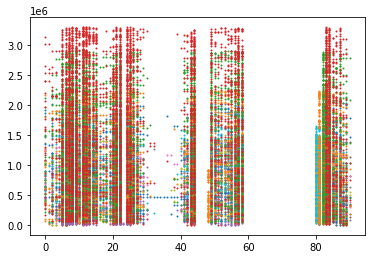

In [145]:
storeMapping = pd.DataFrame(columns=['chr', 'iStart', 'iEnd', 'Fscore'])
for iCh in range(len(Genome)):
    x,y = MappingKmers(reads[iRead],bwtGen,satGen, iCh,k)
    A = findRead(x,y,reads[iRead],Genome,iCh)
    print(A)
    storeMapping = storeMapping.append(A)